# Nepal Earthquake

### Import Libraries and Set Data Source 

In [29]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

In [30]:
import sqlite3
%load_ext sql
%sql sqlite:///nepalDB.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [31]:
%%sql
select * from id_map limit 5

 * sqlite:///nepalDB.db
Done.


household_id,district_id,vdcmun_id,building_id
12010100001101,12,1207,1
12010100002101,12,1207,2
12010100003101,12,1207,3
12010100004101,12,1207,4
12010100005101,12,1207,5


### Prepare Data

In [32]:
%%sql
select distinct (district_id) from id_map

 * sqlite:///nepalDB.db
Done.


district_id
12
20
21
22
23
24
28
29
30
31


In [33]:
%sql select count(distinct(building_id)) from id_map

 * sqlite:///nepalDB.db
Done.


count(distinct(building_id))
747365


In [34]:
%%sql
SELECT DISTINCT im.building_id AS b_id,
    bs.*,
    bd.damage_grade
  FROM temp_map1 tm
       JOIN
       building_structure AS bs ON tm.building_id = bs.building_id
       JOIN 
       building_damage AS bd ON tm.building_id = bd.building_id
       JOIN
       id_map AS im ON im.household_id =tm.household_id 
       where im.district_id=36
        limit 5



 * sqlite:///nepalDB.db
Done.


b_id,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
671455,360101000011,36,3609,360903,1,0,40,336,6,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,Grade 5
671456,360101000021,36,3609,360903,2,2,12,420,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,Grade 3
671457,360101000031,36,3609,360903,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,Grade 2
671458,360101000041,36,3609,360903,2,2,15,390,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,Grade 4
671459,360101000051,36,3609,360903,2,2,15,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Square,0,1,Grade 4


In [35]:
def wrangle(filepath):
    con= sqlite3.connect(filepath)
    
     # Construct query
    query = """
        SELECT DISTINCT im.building_id AS b_id,
    bs.*,
    bd.damage_grade
  FROM temp_map1 tm
       JOIN
       building_structure AS bs ON tm.building_id = bs.building_id
       JOIN 
       building_damage AS bd ON tm.building_id = bd.building_id
       JOIN
       id_map AS im ON im.household_id =tm.household_id 
       where im.district_id=36
    """
    
    #Read Query results into df
    df= pd.read_sql(query, con, index_col='b_id')
    
    #List post_eq data data
    drop_cols=[col for col in df.columns if 'post_eq' in col]
    
    #binary classification
    df['damage_grade']=df['damage_grade'].str.split(' ',expand=True)[1].astype(int)
    df['severity']=(df['damage_grade']>3).astype(int)
    
    #Drop cols for binary classification
    drop_cols.append('damage_grade')
    
    #Drop cols for high cardinality/ leakage/ non relevance
    drop_cols.append('building_id')
    drop_cols.append('district_id')
    drop_cols.append('vdcmun_id')
    drop_cols.append('ward_id')
    
    # Drop cols for low multi collinearity 
    drop_cols.append('count_floors_pre_eq')
    
    #Drop cols
    df.drop(columns=drop_cols, inplace=True)
    
    return df


In [36]:
df=wrangle('./nepalDB.db')
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severity
b_id,,,,,,,,,,,,
671455,40,336,6,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,1,1
671456,12,420,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,0
671457,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,0
671458,15,390,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,1
671459,15,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Square,1,1


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75883 entries, 671455 to 747365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            75883 non-null  int64 
 1   plinth_area_sq_ft       75883 non-null  int64 
 2   height_ft_pre_eq        75883 non-null  int64 
 3   land_surface_condition  75883 non-null  object
 4   foundation_type         75883 non-null  object
 5   roof_type               75883 non-null  object
 6   ground_floor_type       75883 non-null  object
 7   other_floor_type        75883 non-null  object
 8   position                75883 non-null  object
 9   plan_configuration      75883 non-null  object
 10  superstructure          75883 non-null  object
 11  severity                75883 non-null  int32 
dtypes: int32(1), int64(3), object(8)
memory usage: 7.2+ MB


In [38]:
df['severity'].value_counts()

1    47885
0    27998
Name: severity, dtype: int64

### Explore

                   age_building  plinth_area_sq_ft  height_ft_pre_eq
age_building           1.000000          -0.021963          0.035365
plinth_area_sq_ft     -0.021963           1.000000          0.330765
height_ft_pre_eq       0.035365           0.330765          1.000000


Text(0.5, 1.0, 'Collinearity among numerical features Heat Map')

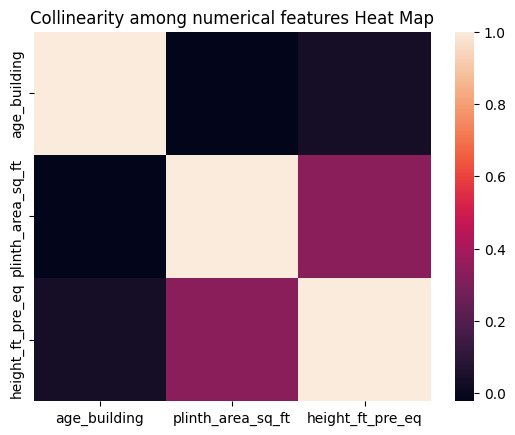

In [39]:
correlation=df.select_dtypes('number').drop(columns='severity').corr()
print(correlation)
sns.heatmap(correlation)
plt.title('Collinearity among numerical features Heat Map')

In [40]:
df['severity'].corr(df['height_ft_pre_eq'])

-0.08591905510494374

In [ ]:
# df['severity'].corr(df['count_floors_pre_eq'])

Text(0.5, 1.0, 'Distribution of Building Height by Class')

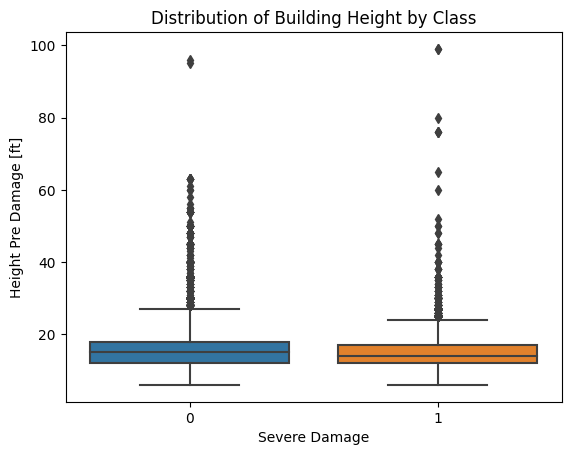

In [ ]:
#Create boxplot

sns.boxplot(x='severity', y='height_ft_pre_eq', data=df)

#Labelling Axes
plt.xlabel('Severe Damage')
plt.ylabel('Height Pre Damage [ft]')
plt.title("Distribution of Building Height by Class")

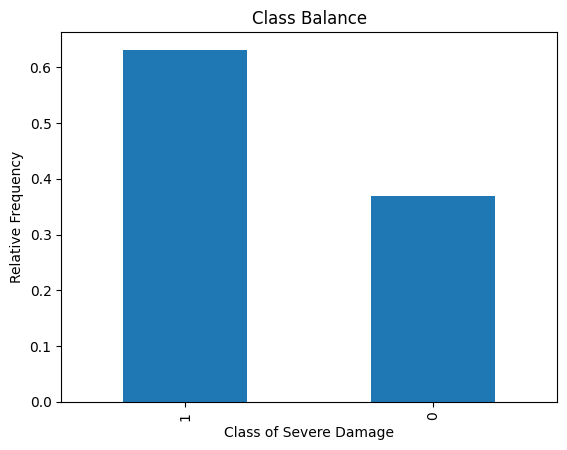

In [43]:
# Plot value counts of `"severe_damage"`
df['severity'].value_counts(normalize=True).plot(
    kind='bar',
    xlabel='Class of Severe Damage',
    ylabel='Relative Frequency',
    title='Class Balance'
);

In [45]:
majority_class_prop, minority_class_prop= df['severity'].value_counts(normalize=True)

print(majority_class_prop, minority_class_prop)

0.6310372547210837 0.3689627452789162


Pivot Table

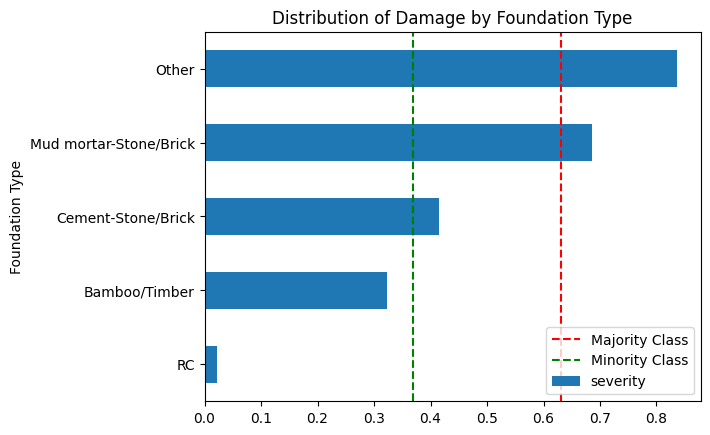

In [48]:
# Create pivot table
# Plot bar chart of `foundation_pivot`
foundation_pivot = pd.pivot_table(
    df,
    index='foundation_type',
    values='severity',
    aggfunc=np.mean
).sort_values(by='severity').plot(
    kind='barh',
    xlabel='Foundation Type',
    title='Distribution of Damage by Foundation Type',
    label='Severity of Damage'
);

plt.axvline(majority_class_prop, linestyle='--',color='red', label='Majority Class' );
plt.axvline(minority_class_prop, linestyle='--',color='green', label='Minority Class' );
plt.legend(loc='lower right');

### Split

In [50]:
target = "severity"
X = df.drop(columns=target)
y = df[target]

In [51]:
X_train, X_test, y_train, y_test =  train_test_split(
    X,y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60706, 11)
y_train shape: (60706,)
X_test shape: (15177, 11)
y_test shape: (15177,)


### Build Model

#### Baseline

In [52]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.63


#### Iterate

In [53]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
) 
# Fit model to training data
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

#### Evaluate

In [54]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.72
Test Accuracy: 0.71


### Communicate

In [55]:
y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred[:5])
print(y_train_pred_proba[:5])

[1 1 1 1 1]
[[0.22816126 0.77183874]
 [0.32604206 0.67395794]
 [0.32918486 0.67081514]
 [0.23335514 0.76664486]
 [0.23019673 0.76980327]]


In [56]:
features = model.named_steps['onehotencoder'].get_feature_names()
importances = model.named_steps['logisticregression'].coef_[0]

In [57]:
odds_ratios =  pd.Series(np.exp(importances), index= features).sort_values()
odds_ratios.head()

foundation_type_RC               0.314553
roof_type_RCC/RB/RBC             0.331632
ground_floor_type_RC             0.419305
other_floor_type_RCC/RB/RBC      0.464109
foundation_type_Bamboo/Timber    0.514135
dtype: float64

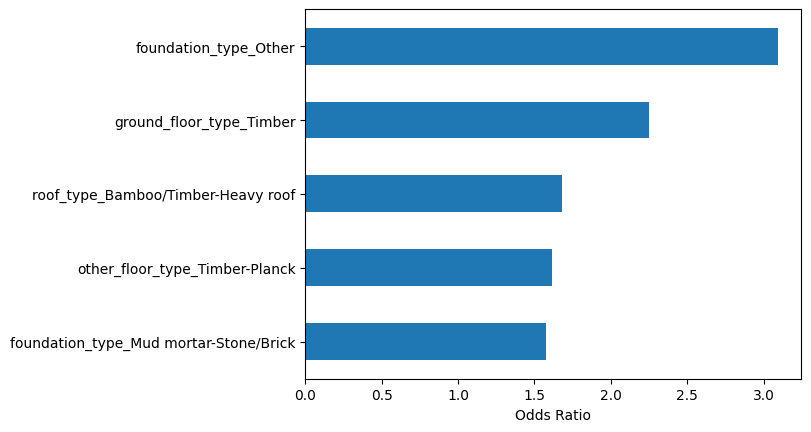

In [58]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind='barh')
plt.xlabel('Odds Ratio');

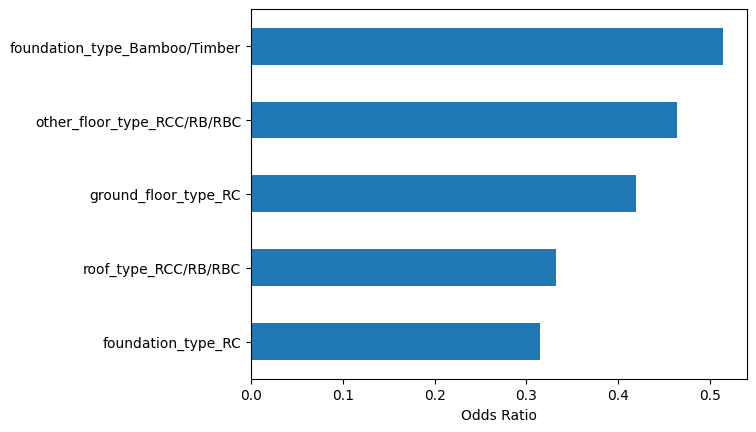

In [59]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind='barh')
plt.xlabel('Odds Ratio');